# Lung Abnormality Detection with ML
### By Haoyuan Pang and Bradley Russavage

In [17]:
# Import required libraries
import os
import cv2 # opencv
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio # tensorflow-io


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

## Functions

In [2]:
main_path = os.getcwd() + '/data/covid_xray/'
train_path = main_path + 'train/'
test_path = main_path + 'test/'

max_dim = 200 # pixels
normal = []
pneumonia = []
classifications = ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation'
                  'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 
                   'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis', 'No finding', 'Pneumonia']

print(len(classifications))

def precision_recall(conf_matrix):
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis=0) - tp 
    fn = np.sum(conf_matrix, axis=1) - tp
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall


def get_metrics(y_test, predicted, title):
    conf_matrix = confusion_matrix(y_test, predicted)
    cm_plot = plt.imshow(conf_matrix)
    plt.colorbar(cm_plot)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([_ for _ in range(len(classifications))], classifications)
    plt.yticks([_ for _ in range(len(classifications))], classifications)
    plt.title(title)
    plt.show()
#     print(pd.DataFrame(conf_matrix, columns=classifications, index=classifications))
#     print("")
#     print(precision_recall(conf_matrix))
    
    
# Requires images to be downloaded
def convert_images(subpath):
    global normal, pneumonia
    for i in ['NORMAL/', 'PNEUMONIA/']:
        path = subpath + i
        for xray in os.listdir(path):
            # print(xray) # image name

            # Convert image to np array using opencv
            try:
                img = cv2.imread(path + xray)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
                img_resize = cv2.resize(img, (max_dim, max_dim), cv2.INTER_AREA) # shrink img to 200 by 200
                
                
                if i == "NORMAL/":
                    normal.append(img_resize)
                    #normal = np.append(normal, img_resize, axis=0)
                else:
                    pneumonia.append(img_resize)
                    #pneumonia = np.append(pneumonia, img_resize, axis=0)
                    
            except Exception as e:
                print(e)

        print("Finished " + i)

15


## Data loading and preprocessing

In [1]:
# Only use these functions if you have the data manually downloaded

# npy_path = "D:\\Downloads\\new_xray\\train\\"
# npy_csv = "D:\\Downloads\\downloaded_npy\\images\\train.csv"

# df = pd.read_csv(npy_csv)
# df = df.loc[:,['image_id','class_id']]

# # Reduce data to be more balanced
# df = df.drop_duplicates(subset=['image_id'])
# df = df.drop(df[df['class_id'] == 14].sample(frac=.97).index)
# df = df.drop(df[df['class_id'] == 0].sample(frac=.7).index)
# df = df.drop(df[df['class_id'] == 3].sample(frac=.7).index)
# df = df.drop(df[df['class_id'] == 13].sample(frac=.4).index)
# df = df.drop(df[df['class_id'] == 11].sample(frac=.3).index)

# # Completely remove
# df = df.drop(df[df['class_id'] == 2].sample(frac=1).index)
# df = df.drop(df[df['class_id'] == 12].sample(frac=1).index)
# df = df.drop(df[df['class_id'] == 1].sample(frac=1).index)
# df = df.drop(df[df['class_id'] == 4].sample(frac=1).index)
# df = df.drop(df[df['class_id'] == 5].sample(frac=1).index)
# df = df.drop(df[df['class_id'] == 6].sample(frac=1).index)

# print(df['class_id'].value_counts())


# multi = []
# y_multi = []

# print(df.shape)

# for i in range(df.shape[0]):
#     name, clf = df.iloc[i]
            
#     try:
# #         img = np.load(npy_path + f"{name}.npy")
#         img = cv2.imread(npy_path + name + ".png")
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img = cv2.resize(img, (max_dim, max_dim), cv2.INTER_AREA)
#         multi.append(img)
#         y_multi.append(clf)
#     except Exception as e:
#         print(e)

# multi = np.asarray(multi)
# y_multi = np.asarray(y_multi)
# print(multi.shape)
# print(y_multi.shape)

In [2]:
# np.save("D:\\Downloads\\new_xray\\multi_reduced.npy", multi)
# np.save("D:\\Downloads\\new_xray\\y_multi_reduced.npy", y_multi)

In [42]:
# Load data from silk server
URL_NORM = "https://brussava.w3.uvm.edu/cs254/covid_xray/normal_arr.npy"
resp = requests.get(URL_NORM)
resp.raise_for_status()
normal = np.load(io.BytesIO(resp.content), allow_pickle=True)

URL_PNEU = "https://brussava.w3.uvm.edu/cs254/covid_xray/pneu_arr.npy"
resp = requests.get(URL_PNEU)
resp.raise_for_status()
pneumonia = np.load(io.BytesIO(resp.content), allow_pickle=True)


print(f"Normal size: {normal.shape}") # should be (1575, 200, 200)
print(f"Pneumonia size: {pneumonia.shape}") # should be (4265, 200, 200)

Normal size: (1575, 200, 200)
Pneumonia size: (4265, 200, 200)


In [4]:
URL_MULTI_X = "https://brussava.w3.uvm.edu/cs254/multi_xray/multi_reduced.npy"
resp = requests.get(URL_MULTI_X)
resp.raise_for_status()
multi_x = np.load(io.BytesIO(resp.content), allow_pickle=True)

print(multi_x.shape)

(7576, 200, 200)


In [6]:
URL_MULTI_y = "https://brussava.w3.uvm.edu/cs254/multi_xray/y_multi_reduced.npy"
resp = requests.get(URL_MULTI_y)
resp.raise_for_status()
multi_y = np.load(io.BytesIO(resp.content), allow_pickle=True)

print(multi_y.shape)

(7576,)


In [43]:
# Reduce dimensionality for both datasets
print("Before flattening")
print(normal.shape)
print(pneumonia.shape)
print(multi_x.shape)

examples_n, dim_x_n, dim_y_n = normal.shape
normal = normal.reshape((examples_n, dim_x_n * dim_y_n))

examples_p, dim_x_p, dim_y_p = pneumonia.shape
pneumonia = pneumonia.reshape((examples_p, dim_x_p * dim_y_p))

examples_m, dim_x_m, dim_y_m = multi_x.shape
multi_x = multi_x.reshape((examples_m, dim_x_m * dim_y_m))

print("\nAfter reduction")
print(normal.shape)
print(pneumonia.shape)
print(multi_x.shape)

Before flattening
(1575, 200, 200)
(4265, 200, 200)
(2516, 200, 200)

After reduction
(1575, 40000)
(4265, 40000)
(2516, 40000)


In [46]:
# Create X and Y
X = np.append(multi_x, normal, axis=0)
X = np.append(X, pneumonia, axis=0)

# index = type, where the value = number of examples of that type 
y = np.append(multi_y, [14 for _ in range(normal.shape[0])], axis=0)
y = np.append(y, [15 for _ in range(pneumonia.shape[0])], axis=0)

del normal, pneumonia, multi_x, multi_y

print(X.shape)
print(y.shape)


# Splitting into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("Training x:", x_train.shape, "y:", y_train.shape)
print("Testing x:", x_test.shape, "y:", y_test.shape)


# Normalize RGB values from 0-255 to 0-1 (div by 255)
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

(8356, 40000)
(8356,)
Training x: (6684, 40000) y: (6684,)
Testing x: (1672, 40000) y: (1672,)


## Random Forest

In [ ]:
# 70 chosen after iterating though different estimators
# rf_class = RandomForestClassifier(n_estimators=110, random_state=0)
# rf_pred = rf_class.fit(x_train, y_train).predict(x_test)
# total = []
# for i in range(70, 150, 10):
#     rf_class = RandomForestClassifier(n_estimators=i, random_state=0)
#     score = rf_class.fit(x_train, y_train).score(x_test, y_test)
#     total.append(score)
#     print(f"{i} finished")
    
# plt.plot(total)

In [ ]:
print(f"Accuracy: {rf_class.score(x_test, y_test)}")
# print(get_metrics(y_test, rf_pred, "Random Forest"))
print(classification_report(y_test, rf_pred))

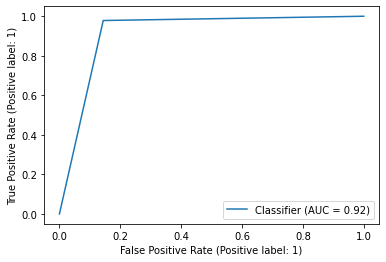

In [10]:
RocCurveDisplay.from_predictions(y_test, rf_pred)
plt.show()

In [14]:
rf_scores = cross_val_score(rf_class, X, y) # Default is 5-fold CV

In [16]:
print(f"RF 5 cv acc: {rf_scores.mean()} std dev: {rf_scores.std()}")

RF 5 cv acc: 0.9294520547945204 std dev: 0.0413469783842178


In [ ]:
# log_reg = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=3, solver='saga', random_state=0)
# log_reg_fit = log_reg.fit(x_train, y_train).predict(x_test)

# log_reg = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=3, solver='saga', max_iter=50, multi_class="multinomial", random_state=0)


## SVM

In [47]:
svc = SVC(kernel="linear", class_weight="balanced", probability=True)
svc_predicted = svc.fit(x_train, y_train).predict(x_test)

### SVM Metrics

In [48]:
print(f"Accuracy: {svc.score(x_test, y_test)}")
# print(get_metrics(y_test, svc_predicted, "SVM"))
# print(classification_report(y_test, svc_predicted))

Accuracy: 0.7063397129186603


In [51]:
# RocCurveDisplay.from_predictions(y_test, svc_predicted)

# auc = roc_auc_score()
# fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(x_test)[:,1])
# auc_t = roc_auc_score(y_test, svc_predicted)
# plt.plot(fpr, tpr, label='SVM')
                                                                         
# plt.show()

In [53]:
# svc_scores = cross_val_score(svc, X, y) # Default is 5-fold CV

In [ ]:
# print(f"SVC 5 cv acc: {svc_scores.mean()} std dev: {svc_scores.std()}")